# [한국어와 NLTK, Gensim의 만남 - PyCon](https://www.lucypark.kr/slides/2015-pyconkr)

박은정 (서울대학교 데이터 마이닝 센터 박사과정) [lucypark](https://github.com/e9t)  
인줄 알았으나 현재 NAVER Corp

---

# "Co-occurrence"
### 두 단어가 정해진 구간 내에서 동시에 등장함

Co-occurrence를 정의하는 두 가지 방법


ocuments = [["나는", "파이썬", "이", "좋다"],
             ["나는", "R", "이", "좋다"]]

* Term-document matrix $X_{td} \in \mathbb{R}^{|V| \times M}$
    + 한 문서에 같이 등장하면 비슷한 단어
```
x_td = [[1, 1],  # 나는
        [1, 0],  # 파이썬
        [0, 1],  # R
        [1, 1],  # 이
        [1, 1]]  # 좋다
```

* Term-term matrix $X_{tt} \in \mathbb{R}^{|V| \times |V|}$ 
    + 단어가 문맥 내에 같이 존재하면 비슷한 단어
    ```
    x_tt = [[0, 1, 1, 2, 0],  # 나는
        [1, 0, 0, 1, 1],  # 파이썬
        [1, 0, 0, 1, 1],  # R
        [2, 1, 1, 0, 2],  # 이
    ```

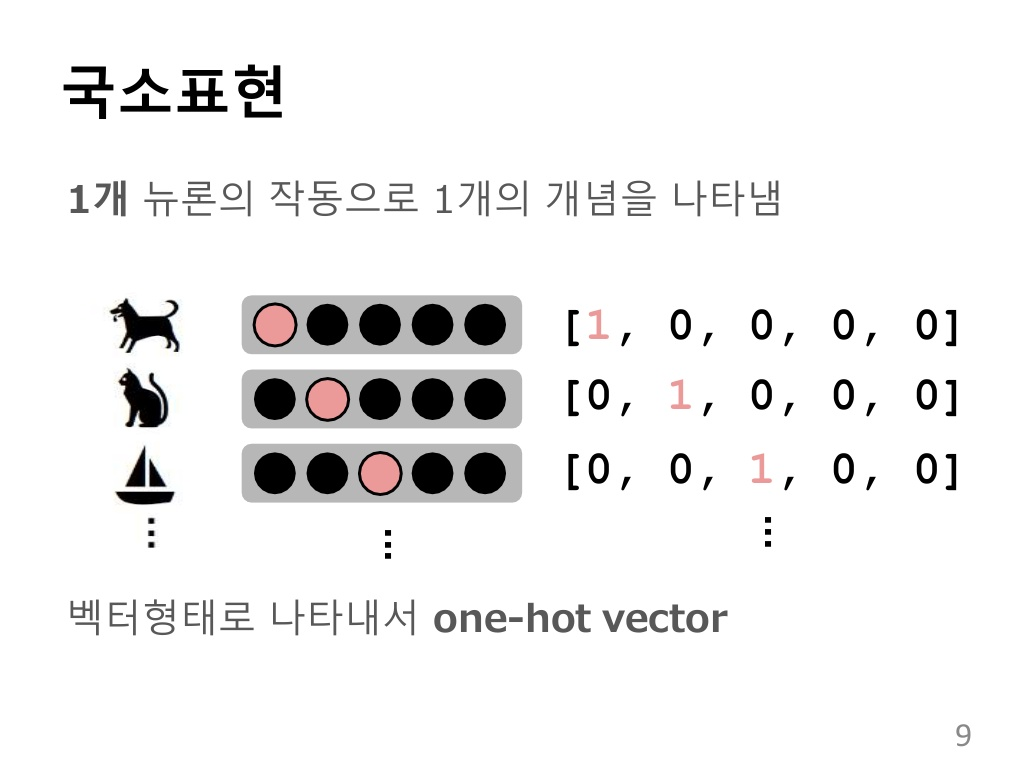

In [132]:
from IPython.display import Image
Image('images/국소표현.png')

### Co-occurrence matrix를 있는 그대로 이용해도 단어 간 유사도를 구할 수는 있다.

In [1]:
import math
def dot_product(v1, v2):
    return sum(map(lambda x: x[0] * x[1], zip(v1, v2)))
def cosine_measure(v1, v2):
    prod = dot_product(v1, v2)
    len1 = math.sqrt(dot_product(v1, v1))
    len2 = math.sqrt(dot_product(v2, v2))
    return prod / (len1 * len2)

하지만 
* 값들이 너무 skewed 되어 있고 (즉, 빈도 높은 단어와 낮은 단어의 격차가 큼)  
* 정보성 낮은 단어 때문에 discriminative하지 않음 (ex: list('은는이가'))   

유사도 정보가 담긴 단어 벡터를 구하는 더 나은 방법은?

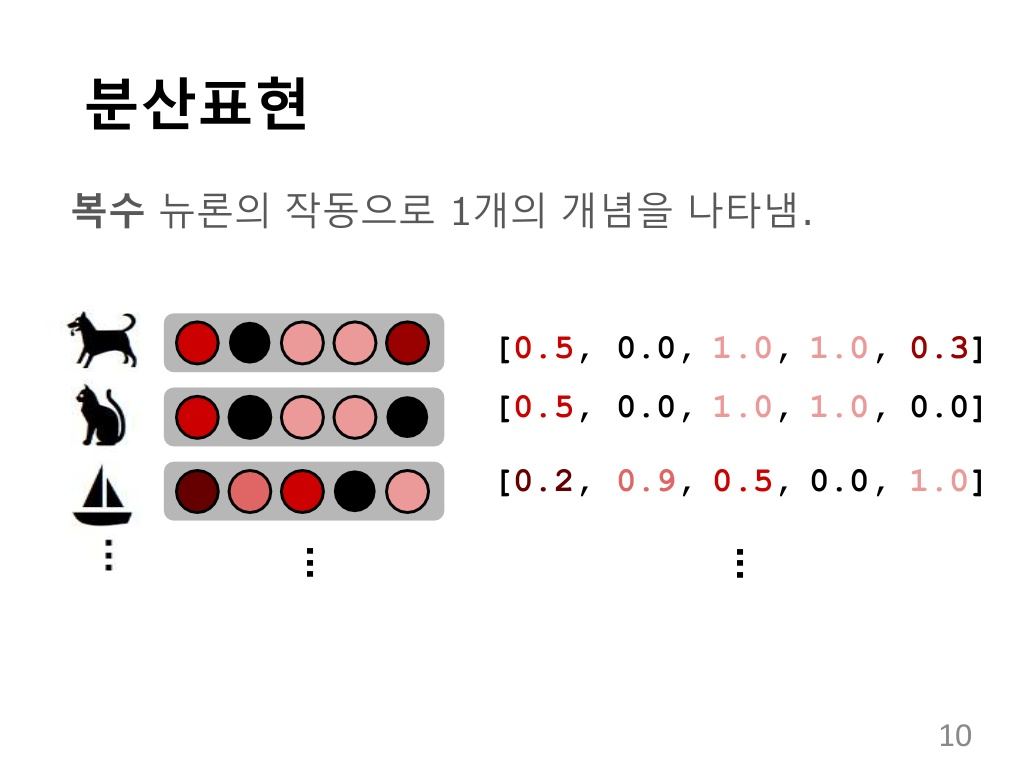

In [133]:
from IPython.display import Image
Image('images/분산표현.png')

 ### word2vec !!!

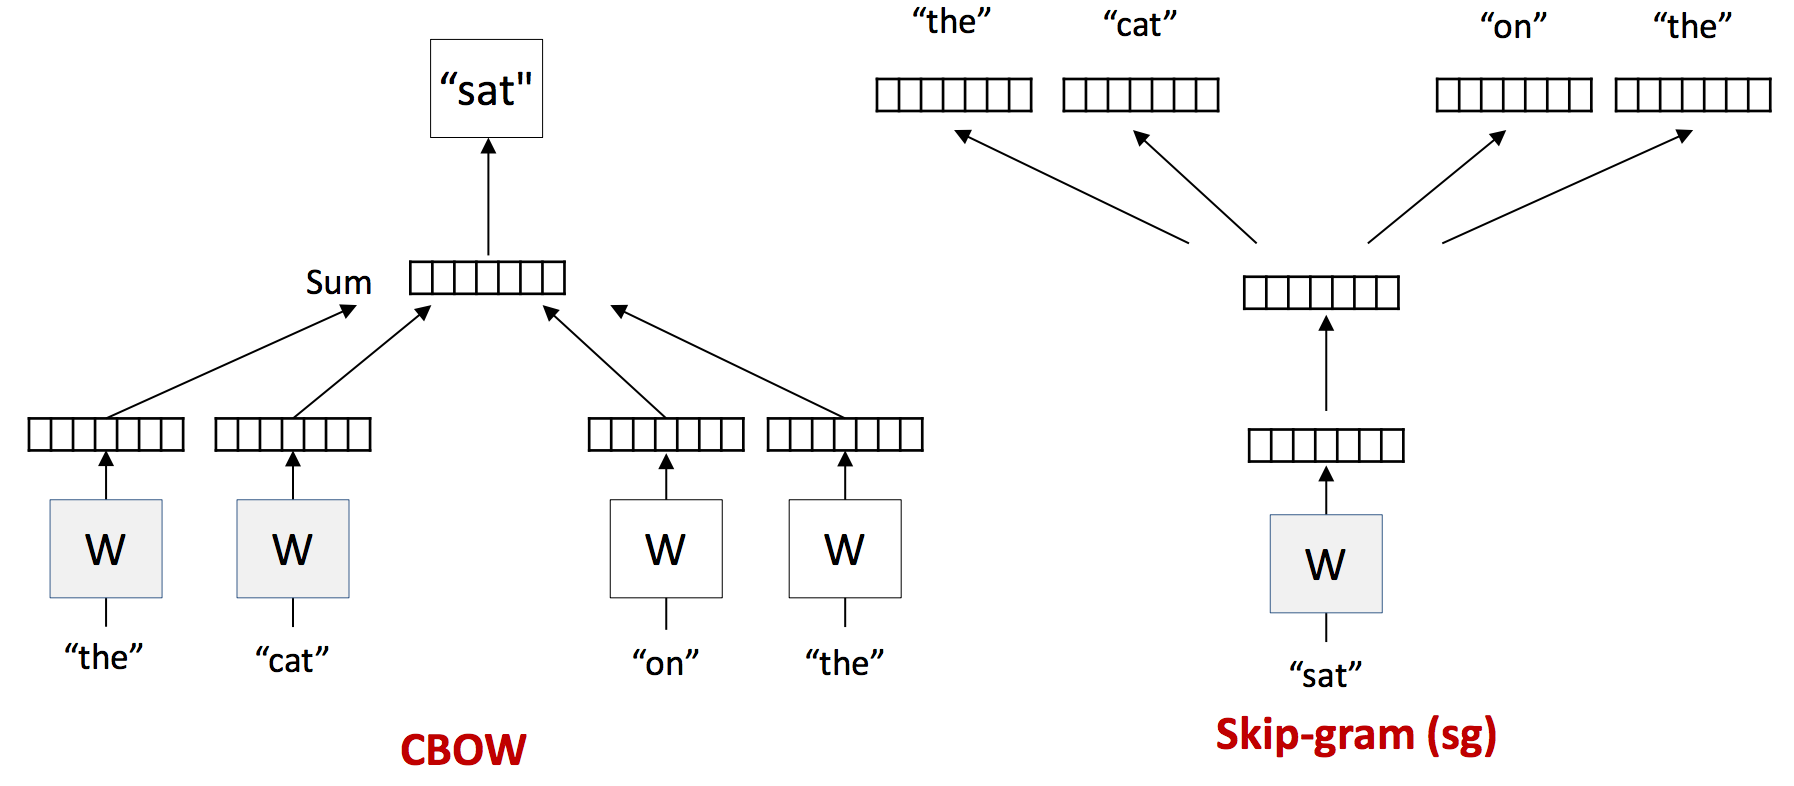

In [2]:
from IPython.display import Image
Image('images/w2v.png')

### [doc2vec !!!](http://cs.stanford.edu/~quocle/paragraph_vector.pdf)

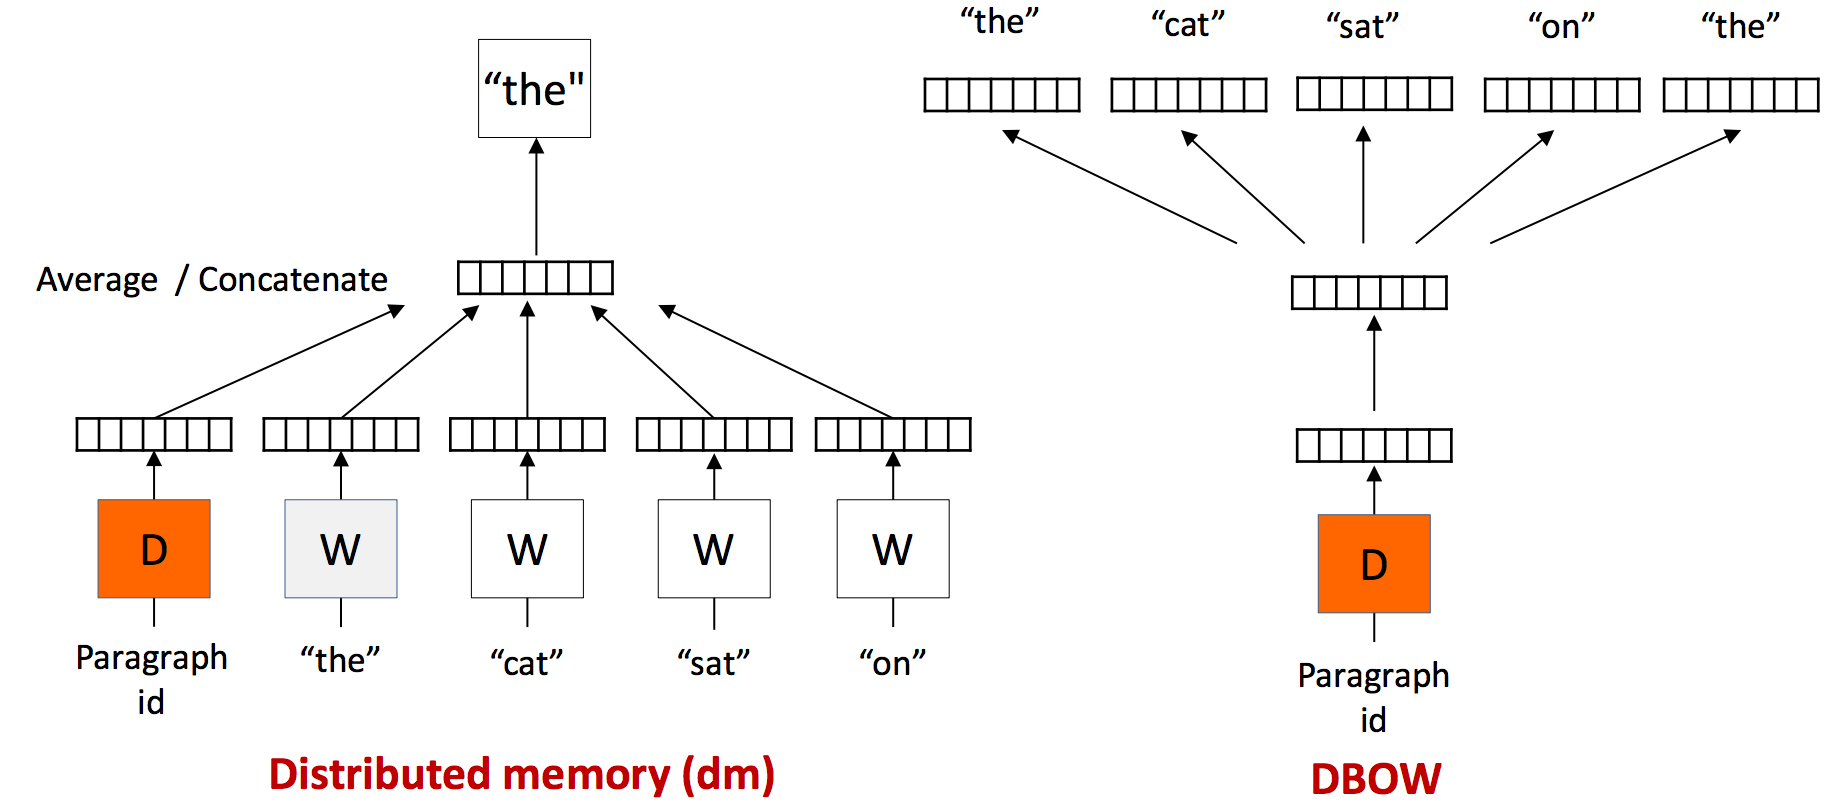

In [3]:
from IPython.display import Image
Image('images/d2v.png')

# 요약

텍스트의 의미를 벡터로 표현하는 몇 가지 방법:

구분 |Sparse, long vectors|	Dense, short vectors
----|--------------------|--------------------------
단어|	1-hot-vectors	   | word2vec
문서|	bag-of-words(term existance, TF, TF-IDF 등)	       | doc2vec



---

# 한국어 영화 리뷰 센티멘트 분석

<h3>순서</h3>

    * KoNLPy 로 데이터 전처리
    * NLTK로 데이터 탐색
    * BOW로 문서 표현하고 classify
    * Gensim으로 doc2vec으로 문서 표현하고 classify

## Data preprocessing (feat. KoNLPy)

#### [데이터 읽기](http://github.com/e9t/nsmc/)

In [12]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data

In [13]:
train_data = read_data('../word2vec/naver/ratings_train.txt')
test_data = read_data('../word2vec/naver/ratings_test.txt')

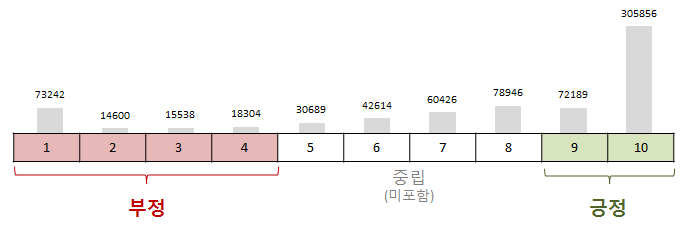

In [26]:
from IPython.display import Image
Image('images/ratingdist.png')

영화당 100개의 140자평을 초과하지 않음  
총 20만개 리뷰(수집된 64만개 중 샘플링)
    * train : 15만
    * test : 5만

별점(1~10)에 따른 긍정 부정 분류  
긍정/부정 리뷰의 비율을 동일하게 샘플링 (중립리뷰 제외)

In [7]:
# row, column의 수가 제대로 읽혔는지 확인
print(len(train_data))      # nrows: 150000
print(len(train_data[0]))   # ncols: 3
print(len(test_data))       # nrows: 50000
print(len(test_data[0]))     # ncols: 3

150000
3
50000
3


#### 형태소로 토크나이징

In [18]:
from konlpy.tag import Twitter
pos_tagger = Twitter()

In [19]:
def tokenize(doc):
    # norm, stem은 optional
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]

조금 오래걸림

In [20]:
train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

In [21]:
# 잘 들어갔는지 확인
from pprint import pprint
pprint(train_docs[0])

(['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증/Noun',
  '나다/Verb',
  '목소리/Noun'],
 '0')


형태소로 꼭 나눠야 하나?
    * 데이터가 정말 충분하다면, 어절 단위로도 가능하겠지만...
    * 김태훈's `시인뉴럴`은 음절단위의 분석

품사(POS)태그를 부착해야 하나?
    * 선택
    * 품사를 태깅하면 동음이의어를 구분할 수 있음

## Data exploration (feat. NLTK)

#### Training data의 token 모으기

In [12]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2194536


2,194,536개의 토큰이 있음

`nltk.Text()`는 문서 하나를 편리하게 탐색할 수 있는 다양한 기능을 제공한다.

In [2]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

NameError: name 'tokens' is not defined

#### returns number of tokens

In [67]:
print(len(text.tokens))                 

2194536


#### returns number of unique tokens

In [68]:
print(len(set(text.tokens)))

48765


#### returns frequency distribution

In [69]:
pprint(text.vocab().most_common(10))

[('./Punctuation', 68630),
 ('영화/Noun', 51365),
 ('하다/Verb', 50281),
 ('이/Josa', 39123),
 ('보다/Verb', 34764),
 ('의/Josa', 30480),
 ('../Punctuation', 29055),
 ('에/Josa', 27108),
 ('가/Josa', 26696),
 ('을/Josa', 23481)]


In [87]:
pprint(text.vocab().most_common()[:-20:-1])

[('황음/Noun', 1),
 ('삼국시대/Noun', 1),
 ('최정우/Noun', 1),
 ('`~~/Punctuation', 1),
 ('그것떄문/Noun', 1),
 ('총몽/Noun', 1),
 ('차악/Noun', 1),
 ('ㅓㅍ/KoreanParticle', 1),
 ('말랭이/Noun', 1),
 ('만창/Noun', 1),
 ('팰땐/Noun', 1),
 ('액션피겨/Noun', 1),
 ('.-.-/Punctuation', 1),
 ('중궈애들/Noun', 1),
 ('조띠/Noun', 1),
 ('대/Noun', 1),
 ('게이코/Noun', 1),
 ('국썅/Noun', 1),
 ('ㅛㅜㅅ/KoreanParticle', 1)]


#### plot tokens by freq.

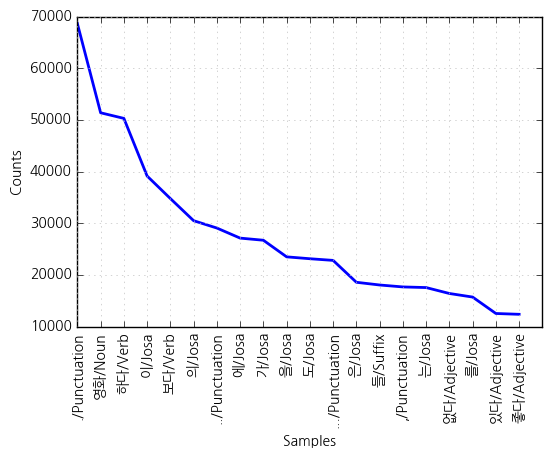

In [70]:
text.plot(20)

#### 폰트 수정..

In [71]:
from matplotlib import font_manager, rc
font_fname = '/usr/share/fonts/nhn-nanum/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

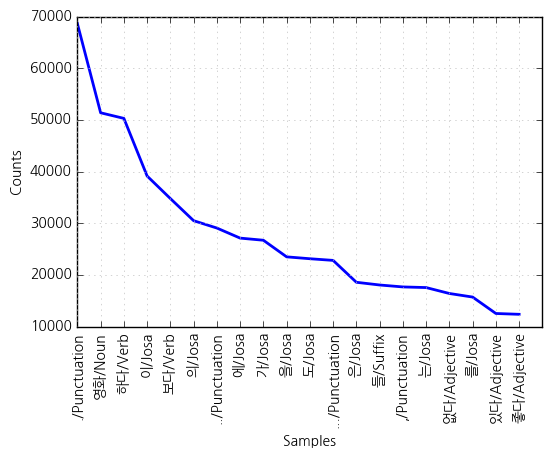

In [72]:
text.plot(20)

In [73]:
text.count("노잼/Noun")

749

In [74]:
text.count("지루/Noun")

253

#### Dispersion plot

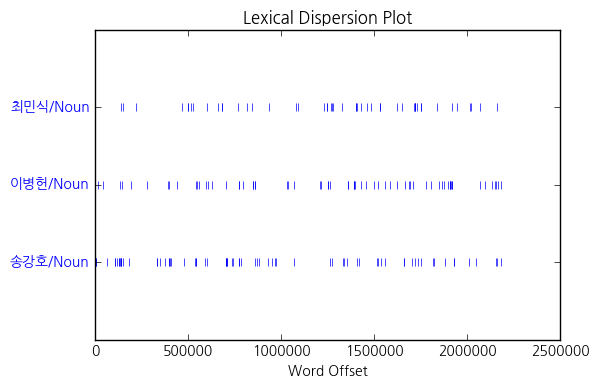

In [75]:
text.dispersion_plot(['최민식/Noun', '이병헌/Noun', '송강호/Noun'])

#### Concordance

In [76]:
text.concordance('시간/Noun')

Displaying 25 of 3899 matches:
rticle 아/Exclamation ../Punctuation 시간/Noun 아깝다/Adjective 재밌다/Adjective 별점/Noun
eanParticle 내/Noun ㅇ/KoreanParticle 시간/Noun 넘다/Verb 아깝다/Adjective 움/Noun ../Pun
tion 평점/Noun 에/Josa 속지/Noun 말다/Verb 시간/Noun 낭비/Noun 돈/Noun 낭비/Noun 임/Noun 리얼리티/
하다/Adjective 난/Noun 별루더/Noun 라/Josa 시간/Noun 낭비/Noun 느낌/Noun 대박/Noun 시청률/Noun 기준
Josa 수작/Noun 이라/Josa 고본/Noun 다/Josa 시간/Noun 이/Josa 아깝다/Adjective 않다/Verb 영화/Nou
Josa 한번/Noun 더/Noun 하다/Verb 되다/Verb 시간/Noun ./Punctuation 그리고/Conjunction 모건/No
/Noun 적/Suffix 계기/Noun 그/Determiner 시간/Noun 이/Josa 표현/Noun 되다/Verb 않다/Verb 시람/N
 좋다/Adjective 뻔하다/Adjective 새벽/Noun 시간/Noun 에/Josa 하다/Verb 일본/Noun 영화/Noun 들/Su
oun 을/Josa 다시/Noun 느끼다/Verb 보다/Verb 시간/Noun 이다/Verb ./Punctuation 장면/Noun 하나/No
실망/Noun ../Punctuation 이/Determiner 시간/Noun 좀/Noun .../Punctuation 밝다/Verb 긍정/N
ctive 드럽/Noun 게/Josa 재미없다/Adjective 시간/Noun 이/Josa 돈/Noun 이다/Josa ?/Punctuation
돈/Noun 이다/Josa ?/Punctuation 내/Noun 시간/Noun 은/Josa 어쩌다/Verb 그저/Adverb 한마디/Noun 
oun 보고/No

#### collocations 인접하게 빈번하게 등장하는 단어

In [20]:
text.collocations()

이/Determiner 것/Noun; 적/Suffix 인/Josa; 이/Determiner 거/Noun; 안/Noun
되다/Verb; 것/Noun 은/Josa; 10/Number 점/Noun; 배우/Noun 들/Suffix; 수/Noun
있다/Adjective; 이/Noun 게/Josa; 내/Noun 가/Josa; 최고/Noun 의/Josa; 네/Suffix
요/Josa; 이/Noun 영화/Noun; 끝/Noun 까지/Josa; 들/Suffix 이/Josa; 봐/Noun
도/Josa; 때문/Noun 에/Josa; 적/Suffix 으로/Josa; 사람/Noun 들/Suffix; 영화/Noun
를/Josa


---

# 고전적 BOW 방식 
# Sentiment classification with term-existance*

#### 여기서는 간단하게 term이 문서에 존재하는지의 유무에 따라 분류를 해보자.

In [21]:
selected_words = [f[0] for f in text.vocab().most_common(2000)]

In [22]:
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

In [23]:
# 시간 단축을 위한 꼼수로 training corpus의 일부만 사용할 수 있음
train_xy = [(term_exists(d), c) for d, c in train_docs]
test_xy = [(term_exists(d), c) for d, c in test_docs]

* 최빈도 단어들은 의미가 없을 수 있다.  
* TF, TF-IDE의 성능은?  
* 코드 최적화(sparse matrix) or scikit-learn의 TfidVectorizer()을 이용!

#### 다양한 분류기를 이용할 수 있다. (nltk 제공)

* [NLTK](http://www.nltk.org/api/nltk.classify.html)
    * Naive Bayes Classifiers
    * Decision Tree Classifiers
    * Maximum Entropy Classifiers
* [scikit-learn](http://www.nltk.org/api/nltk.classify.html#module-nltk.classify.scikitlearn)

### vaive bayses 를 이용한 분류

In [24]:
classifier = nltk.NaiveBayesClassifier.train(train_xy)
print(nltk.classify.accuracy(classifier, test_xy))

0.81652


In [25]:
classifier.show_most_informative_features(10)

Most Informative Features
         exists(최악/Noun) = True                0 : 1      =     68.0 : 1.0
       exists(♥/Foreign) = True                1 : 0      =     57.1 : 1.0
         exists(낚였/Noun) = True                0 : 1      =     48.8 : 1.0
         exists(낭비/Noun) = True                0 : 1      =     47.4 : 1.0
         exists(펑펑/Noun) = True                1 : 0      =     46.1 : 1.0
         exists(반개/Noun) = True                0 : 1      =     41.1 : 1.0
         exists(빵점/Noun) = True                0 : 1      =     34.8 : 1.0
         exists(노잼/Noun) = True                0 : 1      =     33.9 : 1.0
         exists(기세/Noun) = True                0 : 1      =     29.0 : 1.0
         exists(꿀잼/Noun) = True                1 : 0      =     25.5 : 1.0


---

# w2v 방식
# Sentiment classification with doc2vec (feat. [Gensim](http://radimrehurek.com/gensim/))

#### doc2vec으로 리뷰를 긍정/부정으로 분류 for [Gensim](http://radimrehurek.com/gensim/)

In [24]:
from collections import namedtuple

In [25]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

In [26]:
from gensim.models import doc2vec

In [27]:
# 여기서는 15만개 training documents 전부 사용함
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

<h4>Bases: gensim.models.word2vec.Word2Vec</h4>

“distributed memory” (dm) and “distributed bag of words” (dbow).

parameters | explain
-----------|----------------------------------
dm | defines the training algorithm. By default (dm=1), ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.
size | is the dimensionality of the feature vectors.
window | is the maximum distance between the predicted word and context words used for prediction within a document.
alpha | is the initial learning rate (will linearly drop to min_alpha as training progresses).
seed | for the random number generator
min_count | ignore all words with total frequency lower than this.
max_vocab_size | limit RAM during vocabulary building
sample | threshold for configuring which higher-frequency words are randomly downsampled; * default is 1e-3, values of 1e-5 (or lower) may also be useful, value 0. disable downsampling. 
workers | use this many worker threads to train the model
hs | if 1, hierarchical softmax will be used for model training. If set to 0 (default), and negative is non-zero, negative sampling will be used.
negative | if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). Default is 5. If set to 0, no negative samping is used.
dm_mean | if 0 (default), use the sum of the context word vectors. If 1, use the mean. Only applies when dm is used in non-concatenative mode.
dm_concat | if 1, use concatenation of context vectors rather than sum/average; default is 0 (off). Note concatenation results in a much-larger model, as the input is no longer the size of one (sampled or arithmetically combined) word vector, but the size of the tag(s) and all words in the context strung together.
dm_tag_count | expected constant number of document tags per document, when using dm_concat mode; default is 1.
dbow_words | if set to 1 trains word-vectors (in skip-gram fashion) simultaneous with DBOW doc-vector training; default is 0 (faster training of doc-vectors only).
trim_rule | vocabulary trimming rule, specifies whether certain words should remain in the vocabulary, be trimmed away, or handled using the default (discard if word count < min_count). Can be None (min_count will be used), or a callable that accepts parameters (word, count, min_count) and returns either util.RULE_DISCARD, util.RULE_KEEP or util.RULE_DEFAULT. Note: The rule, if given, is only used prune vocabulary during build_vocab() and is not stored as part of the model.



#### DBOW가 좋다고 함 [Doc2Vec to wikipedia articles](https://markroxor.github.io/gensim/static/notebooks/doc2vec-wikipedia.html)

In [90]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

24

In [95]:
# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=1,    # w2v simultaneous with DBOW d2v / default 0
    window=8,        # distance between the predicted word and context words 
    size=300,        # vector size 
    alpha=0.025,     # learning-rate
    seed=1234,
    min_count=20,    # ignore with freq lower
    min_alpha=0.025, # min learning-rate
    workers=cores,   # multi cpu
    hs = 1,          # hierarchical softmax / default 0
    negative = 10,   # negative sampling / default 5
    )

doc_vectorizer.build_vocab(tagged_train_docs)
print(str(doc_vectorizer))

Doc2Vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)


In [99]:
# Train document vectors!

start_time = time.time()
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs)
    doc_vectorizer.alpha -= 0.002  # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha  # fix the learning rate, no decay
check_time = time.time() - start_time
print("During Time : {}".format(check_time))

During Time : 1156.4309272766113


In [100]:
# To save
doc_vectorizer.save('Doc2Vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model')


In [8]:
# load
doc_vectorizer = doc2vec.Doc2Vec.load('Doc2Vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model')
print(str(doc_vectorizer))

Doc2Vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24)


#### 제대로 학습 됐는지 확인

In [101]:
pprint(doc_vectorizer.most_similar('이병헌/Noun'))

[('박찬욱/Noun', 0.2967008650302887),
 ('이미연/Noun', 0.2913372218608856),
 ('씨/Suffix', 0.28002479672431946),
 ('한석규/Noun', 0.26881536841392517),
 ('최민식/Noun', 0.262969434261322),
 ('마동석/Noun', 0.2610626220703125),
 ('송강호/Noun', 0.2603689432144165),
 ('에릭/Noun', 0.2553929388523102),
 ('헐리웃/Noun', 0.2529414892196655),
 ('진구/Noun', 0.2466212809085846)]


In [102]:
pprint(doc_vectorizer.most_similar('ㅋㅋ/KoreanParticle'))

[('ㅋ/KoreanParticle', 0.3849593698978424),
 ('웃기다/Verb', 0.3636508882045746),
 ('대박/Noun', 0.362937331199646),
 ('~~/Punctuation', 0.33044394850730896),
 ('진짜/Noun', 0.3259192407131195),
 ('웃기/Noun', 0.32467594742774963),
 ('존나/Noun', 0.3210976719856262),
 ('완전/Noun', 0.320808082818985),
 ('!!!!/Punctuation', 0.2916632890701294),
 ('ㅎㅎ/KoreanParticle', 0.28924497961997986)]


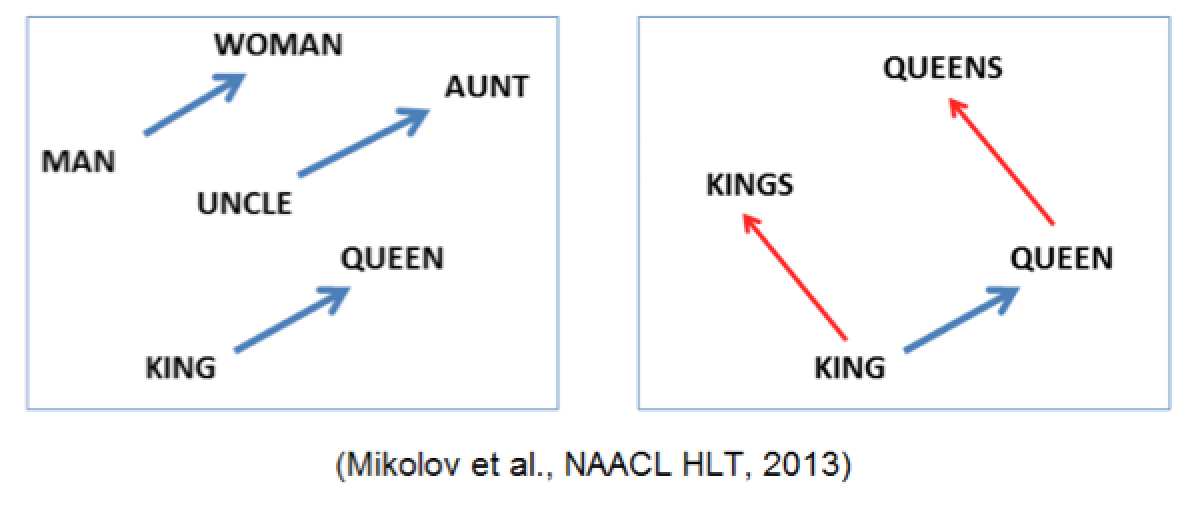

In [151]:
from IPython.display import Image
Image('images/regularities.png')

In [103]:
pprint(doc_vectorizer.most_similar(positive=['여자/Noun', '왕/Noun'], negative=['남자/Noun']))

[('그/Noun', 0.2588029205799103),
 ('어머니/Noun', 0.21909263730049133),
 ('짜증/Noun', 0.21902665495872498),
 ('발음/Noun', 0.21468253433704376),
 ('여동생/Noun', 0.21395841240882874),
 ('트리/Noun', 0.2103133499622345),
 ('허구/Noun', 0.20993314683437347),
 ('뻔/Noun', 0.20431262254714966),
 ('조선/Noun', 0.20392145216464996),
 ('연예인/Noun', 0.2036435902118683)]


한국어는 `왕`이 여러 의미로 사용돼서.. (영어랑 다름)  
다의어 처리하는 기술이라는데[난 모르겠음](https://nlp.stanford.edu/pubs/HuangACL12.pdf)

In [37]:
text.concordance('왕/Noun', lines=10)

Displaying 10 of 145 matches:
Josa 로맨스/Noun 냐/Josa ,,/Punctuation 왕/Noun 짜증/Noun ...../Punctuation 아주/Noun 전
/Noun 함/Noun ../Punctuation 결말/Noun 왕/Noun 실망/Noun 임/Noun 전작/Noun 에/Josa 비/Nou
nction 얼굴/Noun 만/Josa 예쁘다/Adjective 왕/Noun 되다/Verb 맞다/Verb 드라마/Noun 라도/Josa 도덕
/Noun 스릴러/Noun 임/Noun ?/Punctuation 왕/Noun 실망/Noun ./Punctuation 연기/Noun 대본/No
b 금/Noun 사인방/Noun ㅠㅠ/KoreanParticle 왕/Noun 잼/Noun 없다/Adjective ./Punctuation 정
osa 서유기/Noun 보다/Josa 희극/Noun 지/Josa 왕/Noun 이/Josa 더/Noun 최고/Noun 라/Josa 생각/Nou
접/Noun 한/Josa 걸작/Noun ./Punctuation 왕/Noun ,/Punctuation 너무/Noun 감동/Noun 적/Suf
Josa 온/Noun 거/Noun 처럼/Noun 제나라/Noun 왕/Noun 과/Josa 군사/Noun 들/Suffix 을/Josa 속이다/
다/Verb ./Punctuation 기대하다/Adjective 왕/Noun 지루/Noun .../Punctuation 제니퍼/Noun 틸리
tive 움/Noun 짜증/Noun .../Punctuation 왕/Noun 짜증/Noun ../Punctuation 사람/Noun 마다/J


In [117]:
pprint(doc_vectorizer.most_similar(positive=['시간/Noun', '남자/Noun'], negative=['재미/Noun']))

[('여자/Noun', 0.34909266233444214),
 ('돌려주다/Verb', 0.308964341878891),
 ('아깝다/Adjective', 0.2966592609882355),
 ('돌리다/Verb', 0.28225308656692505),
 ('낭비/Noun', 0.2715066373348236),
 ('돈/Noun', 0.26319876313209534),
 ('지나다/Verb', 0.2630499303340912),
 ('인생/Noun', 0.2582603693008423),
 ('주인공/Noun', 0.25809216499328613),
 ('분/Noun', 0.25535041093826294)]


In [28]:
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
len(train_x)  # 사실 이 때문에 앞의 term existance와는 공평한 비교는 아닐 수 있다

150000

In [29]:
import numpy as np

In [107]:
train_x_np = np.asarray(train_x)
train_y_np = np.asarray(train_y, dtype=int)

In [109]:
type(train_x_np[0,0])

numpy.float32

In [31]:
train_x_np.shape

(150000, 300)

In [32]:
train_y_np.shape

(150000,)

##### Word Embedding 이 된 모습이다.

In [33]:
train_x_np[:4, :4]

array([[ 0.07209489, -0.1348388 ,  0.00067386, -0.1314026 ],
       [ 0.0567682 , -0.0859349 ,  0.00775176, -0.20079161],
       [ 0.16047527, -0.36364198, -0.01402055, -0.03804326],
       [ 0.06040307, -0.13231072,  0.25291133,  0.20167877]], dtype=float32)

In [141]:
train_y_np[:4]

array(['0', '1', '0', '0'], 
      dtype='<U1')

두 번째 글이 긍정이다.

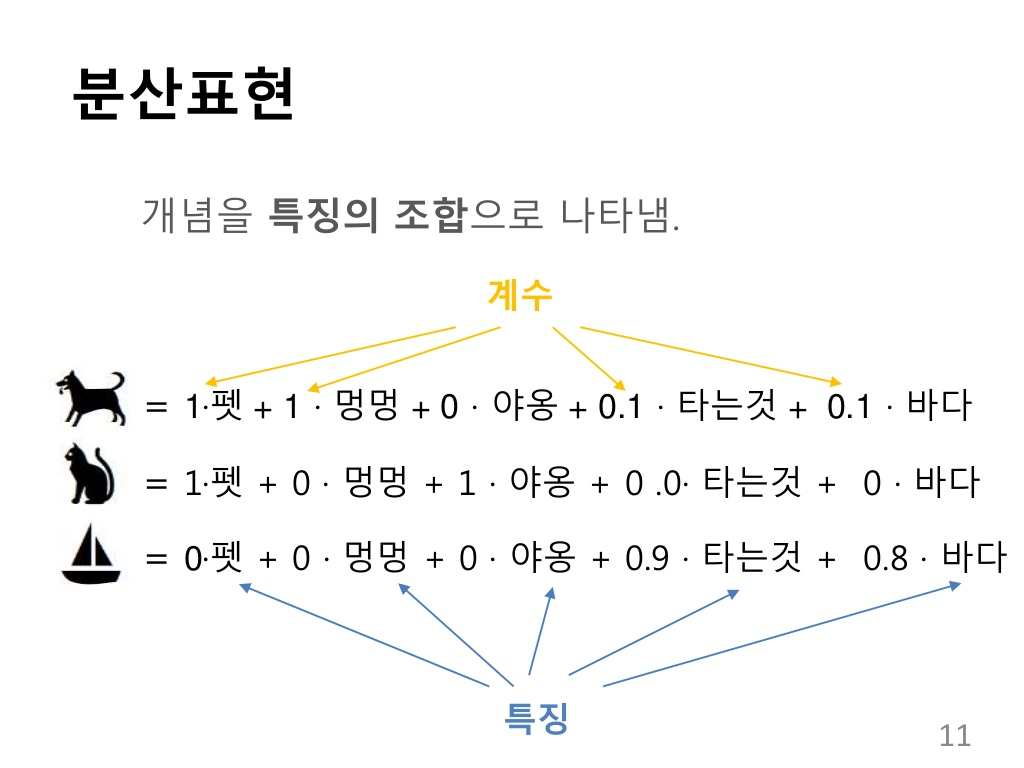

In [131]:
from IPython.display import Image
Image('images/분산표현2.png')

In [107]:
len(train_x[0])

300

In [67]:
test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]
len(test_x)

50000

In [68]:
len(test_x[0])

300

In [122]:
test_x_np = np.asarray(test_x)
test_y_np = np.asarray(test_y, dtype=int)
test_y_np = np.eye(2)[test_y_np.reshape(-1)]

---

### Logistic 회귀를 이용한 분류

In [149]:
from sklearn.linear_model import LogisticRegression

In [150]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)

0.81601999999999997

---

### sklearn neural neworks

In [146]:
from sklearn.neural_network import MLPClassifier

In [148]:
# mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, alpha=1e-4,
#                     solver='sgd', verbose=10, tol=1e-4, random_state=1)
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

mlp.fit(train_x, train_y)
print("Training set score: %f" % mlp.score(train_x, train_y))
print("Test set score: %f" % mlp.score(test_x, test_y))

Iteration 1, loss = 0.39521698
Iteration 2, loss = 0.37263064
Iteration 3, loss = 0.36365129
Iteration 4, loss = 0.35594728
Iteration 5, loss = 0.34919468
Iteration 6, loss = 0.34320344
Iteration 7, loss = 0.33735226
Iteration 8, loss = 0.33217203
Iteration 9, loss = 0.32687282
Iteration 10, loss = 0.32234406


/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Training set score: 0.866840
Test set score: 0.826020


---

### DNN 를 이용한 분류

In [ ]:
from tensorflow.contrib.layers import fully_connected, batch_norm, dropout
from tensorflow.contrib.framework import arg_scope
import tensorflow as tf
import random

In [134]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [136]:
# input place holders
X = tf.placeholder(tf.float32, [None, 300])
Y = tf.placeholder(tf.float32, [None, 2])

# dropout (keep_prob) rate  0.7 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

In [137]:
# weights & bias for nn layers
# http://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
W1 = tf.get_variable("W1", shape=[300, 256],
                     initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([256]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

W2 = tf.get_variable("W2", shape=[256, 256],
                     initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([256]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[256, 256],
                     initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([256]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

W4 = tf.get_variable("W4", shape=[256, 256],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([256]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

W5 = tf.get_variable("W5", shape=[256, 2],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([2]))
hypothesis = tf.matmul(L4, W5) + b5

In [138]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [140]:
# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train_x_np) / batch_size)

    for i in range(0, len(train_x_np), batch_size):
        
        batch_xs = train_x_np[i:i+batch_size]
        batch_ys = train_y_np[i:i+batch_size]
        
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Epoch: 0001 cost = 0.282110077
Epoch: 0002 cost = 0.277017675
Epoch: 0003 cost = 0.275574861
Epoch: 0004 cost = 0.270404877
Epoch: 0005 cost = 0.267390613
Epoch: 0006 cost = 0.263040310
Epoch: 0007 cost = 0.261005293
Epoch: 0008 cost = 0.258696433
Epoch: 0009 cost = 0.256060428
Epoch: 0010 cost = 0.253192582
Epoch: 0011 cost = 0.249791577
Epoch: 0012 cost = 0.247349583
Epoch: 0013 cost = 0.245513382
Epoch: 0014 cost = 0.243545625
Epoch: 0015 cost = 0.242759565
Learning Finished!


In [142]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Accuracy:', sess.run(accuracy, feed_dict={
      X: test_x_np, Y: test_y_np, keep_prob: 1}))

Accuracy: 0.82196


In [145]:
# Get one and predict
r = random.randint(0, len(test_x_np) - 1)
print("Label: ", sess.run(tf.argmax(test_y_np[r:r + 1], 1)))

print("Prediction: ", sess.run(
        tf.argmax(hypothesis, 1),
        feed_dict={X: test_x_np[r:r + 1], keep_prob: 1}))

Label:  [1]
Prediction:  [1]


---

## CNN 을 이용한 분류

In [86]:
tf.reset_default_graph()

In [111]:
train_y_np = np.eye(2)[train_y_np.reshape(-1)]

In [116]:
# parameters
learning_rate = 0.01  # we can use large learning rate using Batch Normalization
training_epochs = 15
batch_size = 100
keep_prob = 0.7

# input place holders
X = tf.placeholder(tf.float32, [None, 300])
Y = tf.placeholder(tf.float32, [None, 2])
train_mode = tf.placeholder(tf.bool, name='train_mode')

# layer output size
hidden_output_size = 300
final_output_size = 2

In [117]:
xavier_init = tf.contrib.layers.xavier_initializer()
bn_params = {
    'is_training': train_mode,
    'decay': 0.9,
    'updates_collections': None
}

In [118]:
# We can build short code using 'arg_scope' to avoid duplicate code
# same function with different arguments
with arg_scope([fully_connected],
               activation_fn=tf.nn.relu,
               weights_initializer=xavier_init,
               biases_initializer=None,
               normalizer_fn=batch_norm,
               normalizer_params=bn_params
               ):
    hidden_layer1 = fully_connected(X, hidden_output_size, scope="h1")
    h1_drop = dropout(hidden_layer1, keep_prob, is_training=train_mode)
    
    hidden_layer2 = fully_connected(h1_drop, hidden_output_size, scope="h2")
    h2_drop = dropout(hidden_layer2, keep_prob, is_training=train_mode)
    
    hidden_layer3 = fully_connected(h2_drop, hidden_output_size, scope="h3")
    h3_drop = dropout(hidden_layer3, keep_prob, is_training=train_mode)
    
    hidden_layer4 = fully_connected(h3_drop, hidden_output_size, scope="h4")
    h4_drop = dropout(hidden_layer4, keep_prob, is_training=train_mode)
    
    hypothesis = fully_connected(h4_drop, final_output_size, activation_fn=None, scope="hypothesis")

In [ ]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [129]:
# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train_x_np) / batch_size)

    for i in range(0, len(train_x_np), batch_size):
        batch_xs = train_x_np[i:i+batch_size]
        batch_ys = train_y_np[i:i+batch_size]
        
        feed_dict_train = {X: batch_xs, Y: batch_ys, train_mode: True}
        feed_dict_cost = {X: batch_xs, Y: batch_ys, train_mode: False}
        
        opt = sess.run(optimizer, feed_dict=feed_dict_train)
        c = sess.run(cost, feed_dict=feed_dict_cost)
        avg_cost += c / total_batch

    print("[Epoch: {:>4}] cost = {:>.9}".format(epoch + 1, avg_cost))
    #print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

[Epoch:    1] cost = 0.238670357
[Epoch:    2] cost = 0.235421863
[Epoch:    3] cost = 0.232591797
[Epoch:    4] cost = 0.229610492
[Epoch:    5] cost = 0.227162077
[Epoch:    6] cost = 0.224461375
[Epoch:    7] cost = 0.223192521
[Epoch:    8] cost = 0.220600032
[Epoch:    9] cost = 0.21881882
[Epoch:   10] cost = 0.216822622
[Epoch:   11] cost = 0.215376576
[Epoch:   12] cost = 0.214159858
[Epoch:   13] cost = 0.21278629
[Epoch:   14] cost = 0.212207559
[Epoch:   15] cost = 0.210148264
Learning Finished!


In [130]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Accuracy:', sess.run(accuracy, feed_dict={
      X: test_x_np, Y: test_y_np, train_mode: False}))

Accuracy: 0.8228


In [131]:
# Get one and predict
r = random.randint(0, len(test_x_np) - 1)
print("Label: ", sess.run(tf.argmax(test_y_np[r:r + 1], 1)))

print("Prediction: ", sess.run(
        tf.argmax(hypothesis, 1),
        feed_dict={X: test_x_np[r:r + 1], train_mode: False}))

Label:  [1]
